# NDVI time series analysis

Given that we have field delineations in the form of polygon geometries, we can perform time-series analyses with NDVI on a number (if not all) field polygons inside the buffer of distributor regions. Using NDVI time-series data, we can start identifying trends and seasonalities and determine cropping/planting cycles in the different regions. Performing time-series analyses on the polygons can also help us on two important areas -

* Time-series data also be used to mask polygons that are not farm land. Polygons which consistently display low NDVI values will be characteristic of regions with very little or not vegetation.
* Disruptions in the seasonality can also hint at factors that may have hindered crop yields.

Here, we test out time-series data generation for a sample polygon in the Trans-Nzoia region.

In [8]:
import os 
from dotenv import load_dotenv
import numpy as np
import geopandas as gpd
import ee
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

import warnings
warnings.filterwarnings('ignore')

In [9]:
load_dotenv()
GEE_PROJECT = os.getenv("GEE_PROJECT")

ee.Authenticate()
ee.Initialize(project=GEE_PROJECT)

## Data

The polygon `.gpkg` file is uploaded for the Trans-Nzoia region and filtered for only `tile_0`.

In [10]:
gdf = gpd.read_file("/Users/rafidmahbub/Desktop/DataKind_Geospatial/samgeo_aws_ec2/vectors/Trans_Nzoia_1.gpkg")

gdf_filtered = gdf[
    gdf["tile_name"] == "tile_0"
]

gdf_filtered.head()

,uuid,region,tile_name,area (sq. meters),area (acres),geometry
27517,b7627b92-5a06-4521-beeb-863c65ee8764,Trans_Nzoia_1,tile_0,25.097259,0.006199,"POLYGON ((34.91154 0.94319, 34.91154 0.94314, ..."
27518,57dfc2af-ca3c-48ee-9efb-421e6453959a,Trans_Nzoia_1,tile_0,99.831319,0.024658,"POLYGON ((34.91244 0.94319, 34.91244 0.94314, ..."
27519,a5bb14bb-cea3-48ab-9325-0890b504433a,Trans_Nzoia_1,tile_0,74.734060,0.018459,"POLYGON ((34.91302 0.94319, 34.91302 0.94314, ..."
27520,9d0c1329-3643-4a95-bda7-51560d154104,Trans_Nzoia_1,tile_0,25.654976,0.006337,"POLYGON ((34.9115 0.94314, 34.9115 0.9431, 34...."
27521,91b3d38e-b77a-494e-bc60-065ce829a0a4,Trans_Nzoia_1,tile_0,25.654976,0.006337,"POLYGON ((34.92439 0.94314, 34.92439 0.9431, 3..."


In [11]:
map = gdf_filtered.explore()
display(map)

## Define functions

Here, we define a few important functions

* `search_polygons()`: This function allows to us search for polygons given only a subset of `uuid`. This for easy selection from an interactive plot.
* `return_gee_geometry()`: Since the polygon data are in incompatible with GEE, this function converts it to a `ee.Geometry` object.
* `mask_cloud_and_shadow()`: This function masks out pixels which are supposed to be clouds and cloud shadows.

In [12]:
def search_polygon(gdf: gpd.GeoDataFrame, id: str) -> np.ndarray:
    """ 
    This function returns a polygon's full uuid by matching the
    first n characters in it.

    Args: (i) gdf - geopandas dataframe containing polygons
          (ii) id - starting uuid substring

    Returns: uuid value(s)
    """

    # Match the starting string id with the uuid column and return match(es)
    n = len(id)
    uuid_df = gdf[["uuid"]]
    uuid_df["match"] = uuid_df["uuid"].apply(lambda row: row[0:n] == id)
    
    idx = uuid_df[uuid_df["match"]==True].index.values.tolist()

    if len(idx) == 0:
        print("No matches found.")

    elif len(idx) >= 1:
        uuid = uuid_df.loc[idx, "uuid"]
        return uuid.values

def return_gee_geometry(gdf: gpd.GeoDataFrame, uuid: str) -> ee.Geometry:
    """ 
    This function converts the polygon geometry associated with a uuid
    to a GEE geometry object. 

    Args: (i) gdf - geopandas dataframe
          (ii) uuid - the polygon uuid for filtering

    Returns: the polygon geometry in the form of an ee.Geometry object
    """
    gdf_RoI = gdf[gdf["uuid"] == uuid]
    RoI = ee.Geometry(gdf_RoI.to_geo_dict()["features"][0]["geometry"])

    return RoI

def mask_cloud_and_shadow(img: ee.Image) -> ee.Image:
    """ 
    This function creates a pixel mask that are deemed to be cloud
    and (or) cloud shadow using Sentinel-2 `MSK_CLDPRB` and
    `Scene Classification Layer`.

    Args: img - ee.Image object

    Returns: same ee.Image object with an updated mask
    """
    cloud_prob = img.select("MSK_CLDPRB")
    snow_prob = img.select("MSK_SNWPRB")
    cloud = cloud_prob.lt(5)
    snow = snow_prob.lt(5)

    # Use SCL to select shadows and cirrus cloud masks
    scl = img.select("SCL")
    shadow = scl.eq(3)
    cirrus = scl.eq(10)

    mask = (
        cloud.And(snow)
        .And(cirrus.neq(1))
        .And(shadow.neq(1))
    )

    return img.updateMask(mask)

def add_NDVI(img: ee.Image) -> ee.Image:
    """ 
    This function takes an ee.Image object and adds an NDVI band to it.

    Args: img - ee.Image object

    Returns: same ee.Image object with an NDVI band 
    """
    ndvi = img.normalizedDifference(["B8", "B4"]).rename("ndvi")
    return img.addBands([ndvi])
    
uuid = search_polygon(gdf, "7851e8b6")[0]
RoI = return_gee_geometry(gdf, uuid)

## Image filtering and NDVI time-series calculation

Using the `S2_SR_HARMONIZED` image collection, we filter the image collection between `START_DATE` and `END_DATE` over a period of three years. The image collection is futher filtered using the RoI and the `mask_cloud_and_shadow()` and `add_NDVI()` functions are subsequently added such that each image in the collection are update with the cloud mask and NDVI band. 

To obtain a time-series, the image collection is converted into a feature collection where the NDVI is average over the polygon in question using the `ee.Reducer.mean()` method. Since cloud masking is applied, we may end up with 'null' values from time to time. These null values are replaced with -9999, which can be later identified from the dataset.

In [13]:
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

img_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate(START_DATE, END_DATE)
    .map(mask_cloud_and_shadow)
    .map(add_NDVI)
    .filter(ee.Filter.bounds(RoI))
).select("ndvi")

def map_ndvi(img: ee.Image) -> ee.Feature:
    stats = img.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=RoI,
        scale=10,
        crs="EPSG:4326"
    )

    ndvi = ee.List([stats.get("ndvi"), -9999]).reduce(ee.Reducer.firstNonNull())
    date = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")

    return ee.Feature(
        None, {
            "ndvi": ndvi,
            "date": date
        }
    )

time_series = ee.FeatureCollection(img_collection.map(map_ndvi))

In [14]:
# Extracting NDVI time-series without uploading to Google Drive

def ndvi_series_df(time_series: ee.FeatureCollection) -> pd.DataFrame:
    """ 
    This function converts GEE NDVI time-series data into a dataframe. This function
    is intended to extract time-series data for single polygons. Collections of 
    polygons should be exported to cloud using ee.batch.Export methods.

    Args: time_series - the NDVI time-series data in the form of ee.FeatureCollection object

    Returns: the NDVI time-series as a pandas dataframe
    """

    # The initial dataframe will contain a dictionary-valued `properties` column
    df = (
        pd.DataFrame(time_series.getInfo()["features"])
        .drop(columns=["type", "geometry"])
    )

    # # The properties column is unpacked
    df[["date", "ndvi"]] = df["properties"].apply(pd.Series)
    df["date"] = pd.to_datetime(df["date"])
    df = df.drop(columns=["properties"])

    # start_date = pd.to_datetime("2022-01-01")
    # df["days_elapsed"] = df["date"].apply(lambda row: (row - start_date).days)
    # df["days_elapsed"] = df["days_elapsed"].astype("Int32")

    return df

Export time-series data to Google Drive.

In [15]:
# task = ee.batch.Export.table.toDrive(
#     collection=time_series,
#     description='ndvi_time_series',
#     folder='ee_demos',
#     fileFormat='CSV',
# )
# task.start()

## Sample NDVI time-series plot

Now, we can plot the sample NDVI time-series. Pre-processing steps include converting the `date` into pandas `datetime` objects and filtering the data for the -9999 null values.

In [16]:
#ndvi_series = pd.read_csv("ndvi_time_series.csv")
ndvi_series = ndvi_series_df(time_series)

ndvi_series = ndvi_series[ndvi_series["ndvi"] != -9999.000000]
ndvi_series["date"] = pd.to_datetime(ndvi_series["date"])
ndvi_series = ndvi_series.drop_duplicates(subset=["date"], keep="first")
ndvi_series.head()

,id,date,ndvi
0,20200102T075229_20200102T080825_T36NYG,2020-01-02,0.497022
1,20200107T075311_20200107T075626_T36NYG,2020-01-07,0.158185
2,20200112T075209_20200112T080017_T36NYG,2020-01-12,0.154410
3,20200117T075241_20200117T075557_T36NYG,2020-01-17,0.159150
4,20200122T075129_20200122T080758_T36NYG,2020-01-22,0.118168


The NDVI data shows very clear seasonality with quite well-defined peaks and troughs. The peaks during the middle of the year represent crop growth occurring during the middle of the year. Furthermore, the data points can also be fitted to a simple harmonic model. We assume the following model

$$ \text{NDVI}(t) = a_0 + a_1 t + a_2 \cos(2\pi f t) + a_3\sin(2\pi f t) + \cdot\cdot\cdot $$

Then the data can be fitted to this curve to determine the fitting coefficients.


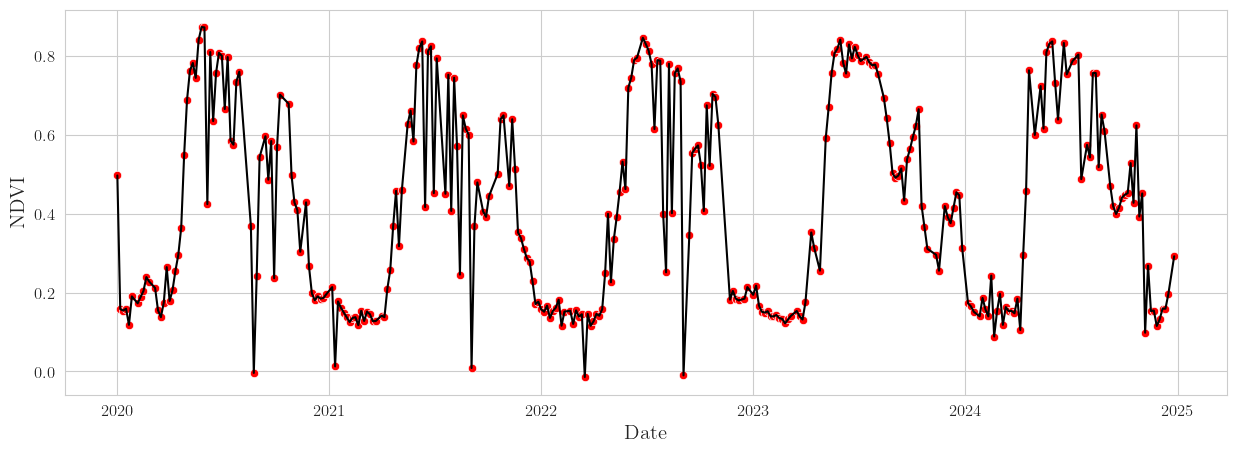

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.scatterplot(ndvi_series, x="date", y="ndvi", color="red", ax=ax)
sns.lineplot(ndvi_series, x="date", y="ndvi", color="black", ax=ax)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("NDVI", fontsize=15)

#plt.savefig("sample_ndvi_timeseries_transnzoia.png", dpi=300, bbox_inches="tight")
plt.show()

## Generalizing calculations to multiple polygons

Upto now, the time-series analysis has been focused on a single region. However, our data consists of hundreds of thousands of polygons. Hence, we require a computationally effective way of performing these calculations for each polygon in our dataset. The overall objective would be as follows-

* Generate NDVI time-series data for each polygon over a three year span
* Append these data to existing .gpkg/.csv data files as an extra column
* Use time-series data to include additional tags indicating number of peaks in the NDVI time-series and using such variations as a means to ruling out possible non-field polygon layes. We expect non-vegetation polygons to display consistently low NDVI.

### Converting `shapely.geometry` objects into `ee.Geometry` objects

Geometries stored in geopandas are created using `shapely.geometry` objects. However, GEE uses the geojson format for storing geometric information. As a first step, the `geometry` column is mapped into an `ee.Geometry` column. These can then be aggregated into an `ee.FeatureCollection` object with attached metadata.

In [18]:
import json
import shapely
from shapely.geometry import Polygon 

def return_ee_geometry(poly: Polygon) -> ee.Geometry:
        # shapely.to_geojson() returns a string object which needs to be
        # converted to geojson before using with ee.Geometry
        RoI = ee.Geometry(json.loads(shapely.to_geojson(poly)))

        return RoI

gdf_filtered["RoI"] = gdf_filtered["geometry"].apply(return_ee_geometry)

gdf_filtered.head()

,uuid,region,tile_name,area (sq. meters),area (acres),geometry,RoI
27517,b7627b92-5a06-4521-beeb-863c65ee8764,Trans_Nzoia_1,tile_0,25.097259,0.006199,"POLYGON ((34.91154 0.94319, 34.91154 0.94314, ...","ee.Geometry({\n ""functionInvocationValue"": {\..."
27518,57dfc2af-ca3c-48ee-9efb-421e6453959a,Trans_Nzoia_1,tile_0,99.831319,0.024658,"POLYGON ((34.91244 0.94319, 34.91244 0.94314, ...","ee.Geometry({\n ""functionInvocationValue"": {\..."
27519,a5bb14bb-cea3-48ab-9325-0890b504433a,Trans_Nzoia_1,tile_0,74.734060,0.018459,"POLYGON ((34.91302 0.94319, 34.91302 0.94314, ...","ee.Geometry({\n ""functionInvocationValue"": {\..."
27520,9d0c1329-3643-4a95-bda7-51560d154104,Trans_Nzoia_1,tile_0,25.654976,0.006337,"POLYGON ((34.9115 0.94314, 34.9115 0.9431, 34....","ee.Geometry({\n ""functionInvocationValue"": {\..."
27521,91b3d38e-b77a-494e-bc60-065ce829a0a4,Trans_Nzoia_1,tile_0,25.654976,0.006337,"POLYGON ((34.92439 0.94314, 34.92439 0.9431, 3...","ee.Geometry({\n ""functionInvocationValue"": {\..."


### Creating `FeatureCollection` from RoIs

All the RoI geometries are aggregated into an `ee.FeatureCollection` object.

In [19]:
def gdf_to_FC(gdf: gpd.GeoDataFrame) -> ee.FeatureCollection:
    """ 
    This function converts each RoI in the geodataframe into an
    ee.Feature object with attached metadata. All the features are
    then aggregated into an ee.FeatureCollection object.
    """
    features = []

    for idx, row in gdf.iterrows():
        feature = ee.Feature(row["RoI"])
        metadata = {
            "region": row["region"],
            "tile_name": row["tile_name"],
            "uuid": row["uuid"]
        }
        feature = feature.set(metadata)

        features.append(feature)
    
    return ee.FeatureCollection(features)

FC = gdf_to_FC(gdf_filtered)

### Map NDVI function over all images

The image collection, after being filtered, is passed through the `map_ndvi()` function, which applies the reducer to all the images for calculating the spatially averaged NDVI. The NDVI data for all the images are processed into a table that is exported to Google Drive.

In [20]:
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

img_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate(START_DATE, END_DATE)
    .filterBounds(FC)
    .map(mask_cloud_and_shadow)
    .map(add_NDVI)
).select("ndvi")

def clip_img_collection(img: ee.Image) -> ee.Image:
    return img.clip(FC)

img_collection_clipped = img_collection.map(clip_img_collection)

def map_ndvi(img: ee.Image):
    stats =img.reduceRegions(
        collection=FC,
        reducer=ee.Reducer.mean().setOutputs(["ndvi"]),
        scale=10
    ).filter(ee.Filter.neq("ndvi", None)) # Filter out null NDVI values

    def set_date(feature: ee.Feature):
        return feature.set("date", img.date().format("YYYY-MM-dd"))
    
    return stats.map(set_date)
# def map_ndvi(img: ee.Image) -> ee.Feature:
#     stats = img.reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=RoI,
#         scale=10
#     )

#     ndvi = ee.List([stats.get("ndvi"), -9999]).reduce(ee.Reducer.firstNonNull())
#     date = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")

#     return ee.Feature(
#         None, {
#             "ndvi": ndvi,
#             "date": date
#         }
#     )

data = img_collection_clipped.map(map_ndvi).flatten()

In [21]:
def format_table(table, row_id, col_id):
    # Get unique rows based on rowId
    rows = table.distinct(row_id)

    # Create join condition
    condition = ee.Filter.equals(leftField=row_id, rightField=row_id)

    # Perform the join
    joined = ee.Join.saveAll('matches').apply(primary=rows, secondary=table, condition=condition)

    # Map over joined results
    def map_row(row):
        matches = ee.List(row.get('matches'))

        def extract_values(feature):
            feature = ee.Feature(feature)
            ndvi_val = ee.List([feature.get('ndvi'), -9999]).reduce(ee.Reducer.firstNonNull())
            return [feature.get(col_id), ee.Number(ndvi_val).format('%.3f')]

        # Get list of [colId, ndvi] pairs
        values = matches.map(extract_values)

        # Flatten and convert to dictionary
        flat_values = ee.Dictionary(ee.List(values).flatten())

        # Return row with the wide-format values added
        return row.select([row_id]).set(flat_values)

    return ee.FeatureCollection(joined.map(map_row))

NDVI_Results = format_table(data, 'uuid', 'date')

In [22]:
# task = ee.batch.Export.table.toDrive(
#     collection=NDVI_Results,
#     description='NDVI_Results',
#     folder='ee_demos',
#     fileFormat='CSV',
# )
# task.start()

In [23]:
#task.status()

### Cleaning an imputation

The table exported to Google Drive is exported in a format where each row corresponds to the polygons contained in the geometries and the columns containing the dates in `string` format. Moreover, the data contains numerous `NaN` values. These are imputed using the `bfill` method. However, there may be rows where the final NDVI entry are missing. In such cases, they are filled using `ffill`. Then, the dataframe is melted such that date columns are now stored in rows with all the polygon data appended to each other, in a sorted fashion.

In [24]:
def fill_dates(row: pd.Series) -> pd.Series:
    """ 
    This function implements a smart imputation strategy such that
    rows with missing entries at starting date is imputed with `bfill`
    while those with missing entries at the end are imputed with `ffill`.
    For others, it defaults to `bfill`.
    """
    if pd.isna(row.iloc[0]):
        row = row.fillna(method="bfill")
        return row
    elif pd.isna(row.iloc[-1]):
        row = row.fillna(method="ffill")
        return row
    else:
        row = row.fillna(method="bfill")
        return row

def clean_ndvi_series(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=["system:index", ".geo"]) # Remove useless columns

    uuid_col = df.columns[-1]
    new_cols = [uuid_col] + list(df.columns[:-1])
    df = df.reindex(columns=new_cols)

    # Isolate only the numerical portion of the dataframe
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(fill_dates, axis=1)

    df_melted = (
        df.melt(id_vars="uuid", var_name="date", value_name="ndvi")
          .groupby("uuid", group_keys=False).apply(lambda row: row.sort_values(by="date", ascending=False))
    )
    df_melted["date"] = pd.to_datetime(df_melted["date"])
    df_melted = df_melted.drop_duplicates(subset=["uuid", "date"], keep="first")

    return df_melted.reset_index(drop=True)

In [25]:
ndvi_series_tile_0 = pd.read_csv("Trans_Nzoia_1_tile_0_NDVI.csv")

ndvi_series_tile_0 = clean_ndvi_series(ndvi_series_tile_0)
ndvi_series_tile_0

,uuid,date,ndvi
0,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-26,0.327
1,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-16,0.327
2,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-11,0.364
3,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-06,0.359
4,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-01,0.120
...,...,...,...
524155,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-02-11,0.560
524156,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-01-22,0.449
524157,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-01-17,0.459
524158,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-01-12,0.352


All NaN values have been properly imputed.

In [26]:
ndvi_series_tile_0.isna().value_counts()

uuid   date   ndvi 
False  False  False    524160
Name: count, dtype: int64

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
import ipywidgets as widgets
#from ipywidgets import interact, interact_manual
from IPython.display import display

def plot_timeseries(uuid: str) -> None:
    df_subset = ndvi_series_tile_0[
        ndvi_series_tile_0["uuid"] == uuid
    ]

    fig, ax = plt.subplots(2, 1, figsize=(15, 10))

    sns.scatterplot(df_subset, x="date", y="ndvi", ax=ax[0])
    sns.lineplot(df_subset, x="date", y="ndvi", alpha=0.5, ax=ax[0])
    ax[0].set_xlabel("Date", fontsize=15)
    ax[0].set_ylabel("Mean NDVI", fontsize=15)
    ax[0].set_ylim(-0.1, 1.1)

    N = len(df_subset["ndvi"])

    plot_acf(df_subset["ndvi"], lags=N/2, title='', ax=ax[1])
    ax[1].set_xlabel("Lags", fontsize=15)
    ax[1].set_ylabel("ACF", fontsize=15)
    #ax[1].set_ylim(-1.1, 1.1)

    plt.show()

uuid_list = ndvi_series_tile_0["uuid"].unique().tolist()
uuid_dropdown = widgets.Dropdown(
    options=uuid_list
)
ui = widgets.HBox([uuid_dropdown])

output = widgets.interactive_output(
    plot_timeseries, {'uuid': uuid_dropdown}
)
display(ui, output)

Output()